# Forecasting moss & lichen fractional cover 
# **No weights** in the loss function
## with a Neural Network using Keras
## (Reading X and Y train/test files stored locally)
### Using only 2m temperature and total precipitation from ERA5-land
### For lichen output only

In [1]:
#!pip install -v tensorflow tables

In [2]:
print('Starting imports')
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Input, BatchNormalization, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, SGD, Adadelta
from tensorflow.keras import Sequential
print('Finished imports')

Starting imports


2023-04-12 18:02:13.022813: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-12 18:02:13.129489: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-12 18:02:13.130792: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-12 18:02:13.970654: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Finished imports


In [3]:
# Sets all random seeds for the program to make it fully deterministic
tf.keras.backend.experimental.enable_tf_random_generator()
tf.keras.utils.set_random_seed(12345)

In [4]:
# Defining various parameters

depth = 1
width = 8
epochs = 16
activation = 'relu'
final_activation = 'sigmoid'
batch_size = 128
learning_rate = 0.01
rho = 0.9
loss = 'Huber'
validation_split = 0.01
print('Depth = ', depth)
print('Width = ', width)
print('Hidden layer activation = ', activation)
print('Final activation = ', final_activation)
print('Learning rate = ', learning_rate)
print('Epochs = ', epochs)
print('Batch size = ', batch_size)
print('Loss function = ', loss)
print('Validation split = ', validation_split)
expname = 'TP1_365d_' + str(depth) + '_' + str(width) + '_' + str(epochs) + 'epochs-' + str(batch_size) + '_' + activation + '-' + final_activation + '_Adadelta-' + str(learning_rate) + '-' + str(rho) + '_' + loss + '_' + str(validation_split) + 'split'
print('Experiment name = ', expname)

Depth =  1
Width =  8
Hidden layer activation =  relu
Final activation =  sigmoid
Learning rate =  0.01
Epochs =  16
Batch size =  128
Loss function =  Huber
Validation split =  0.01
Experiment name =  TP1_365d_1_8_16epochs-128_relu-sigmoid_Adadelta-0.01-0.9_Huber_0.01split


# **All years** of input/output data - for training

In [5]:
# Read local .hdf5 file
path = '/home/jovyan/data/'

print('Reading X_train')
X_train_file = os.path.join(path, 'X_mean_tp1_train.hdf')
input_train = pd.read_hdf(X_train_file)
input_train.fillna(0, inplace=True)
Ni_train = input_train['N']
input_train = input_train.drop(columns=['N'])

print('Reading X_test')
X_test_file = os.path.join(path, 'X_mean_tp1_test.hdf')
input_test = pd.read_hdf(X_test_file)
input_test.fillna(0, inplace=True)
Ni_test = input_test['N']
input_test = input_test.drop(columns=['N'])

print('Reading y_train')
y_train_file = os.path.join(path, 'y_mean_tp1_train.hdf')
output_train = pd.read_hdf(y_train_file)
output_train.fillna(0, inplace=True)
No_train = output_train['new_N']
output_train = output_train.drop(columns=['new_N'])

print('Reading y_test')
y_test_file = os.path.join(path, 'y_mean_tp1_test.hdf')
output_test = pd.read_hdf(y_test_file)
output_test.fillna(0, inplace=True)
No_test = output_test['new_N']
output_test = output_test.drop(columns=['new_N'])

Reading X_train
Reading X_test
Reading y_train
Reading y_test


In [6]:
train_loss_weights = (Ni_train + No_train) / 2.

In [7]:
test_loss_weights = (Ni_test + No_test) / 2.

In [8]:
input_train

,Lichen_mean,t2m_0,t2m_1,t2m_2,t2m_3,t2m_4,t2m_5,t2m_6,t2m_7,t2m_8,...,tp_8750,tp_8751,tp_8752,tp_8753,tp_8754,tp_8755,tp_8756,tp_8757,tp_8758,tp_8759
37,0.206957,0.980098,0.979132,0.978012,0.977067,0.976765,0.976962,0.977570,0.978795,0.979352,...,6.355690,6.567183,6.741878,6.785994,6.881322,6.917901,6.949824,6.968003,6.975762,6.979531
3398,0.015000,0.970166,0.969656,0.969405,0.968324,0.966665,0.966376,0.967062,0.973468,0.976268,...,0.119935,0.124812,0.127694,0.129911,0.131463,0.132793,0.135232,0.139000,0.144321,0.149420
2747,0.070000,0.977087,0.976450,0.976084,0.975476,0.974517,0.973572,0.972440,0.972063,0.972751,...,0.104860,0.105747,0.106633,0.107077,0.107077,0.107077,0.107520,0.107520,0.107742,0.108185
2765,0.154400,0.958038,0.957104,0.956431,0.956065,0.956249,0.956804,0.959287,0.971047,0.975480,...,0.467105,0.587705,0.653326,0.741116,0.821369,0.901399,0.960148,1.040179,1.130186,1.183392
675,0.041406,0.983774,0.982896,0.982884,0.983259,0.983792,0.983668,0.983439,0.984586,0.984245,...,4.277105,4.350263,4.396375,4.416992,4.427412,4.435615,4.442487,4.452242,4.463104,4.475963
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
835,0.068799,1.002590,1.001667,1.001438,1.001973,1.002242,1.001443,1.000540,1.003932,1.004480,...,1.871967,1.893471,1.905000,1.911651,1.912537,1.941135,1.966630,1.974389,1.975054,1.975054
3264,0.037297,0.973907,0.973860,0.973341,0.972123,0.970306,0.968702,0.966749,0.968500,0.970184,...,0.040570,0.043895,0.046555,0.048107,0.049437,0.050546,0.051876,0.053427,0.054314,0.055201
1653,0.137132,0.936202,0.935841,0.934713,0.932728,0.931330,0.930444,0.928849,0.931634,0.932550,...,0.866151,0.887212,0.917361,0.949063,0.967242,0.977883,0.985643,0.993402,1.001826,1.012911
2607,0.156667,0.986397,0.987282,0.988230,0.990242,0.990626,0.991209,0.991420,0.989903,0.988334,...,3.165541,3.463938,3.630208,3.727752,3.781623,3.860102,3.943680,4.023046,4.088888,4.125911


In [9]:
output_test

,new_Lichen_mean
989,0.070000
686,0.062664
472,0.070323
3231,0.117059
3351,0.133754
...,...
3268,0.074000
1559,0.104855
547,0.104464
3251,0.138932


In [10]:
def fullyconnected_sequential(
    input_shape: int,  # How many predictors?
    width: int,  # How wide should the layers be?
    depth: int,  # How many layers?
    activation: str,  # What nonlinearity to use?
    final_activation: str,  # Output layer?
    learning_rate: float,  # What learning rate?
    loss: str,  # What loss function?
):
    # Create a model object
    model = Sequential()

    # Then just stack layers on top of one another
    # the first specifies the shape of the inputs expected input
    model.add(Input(input_shape, name = 'Inputs'))

    # Then we stack on depth number of consectutive dense layers
    # To write more compact code we can include the activation
    # function we want to apply after each Dense block in the
    # call itself.
    for i in range(depth):
        model.add(Dense(width, activation = activation))

    # Finally we add an output layer, we want to predict
    # 1 variable, and we will probably use a linear output
    # layer, so we don't constrain the output
    model.add(Dense(1, activation = final_activation))

    # Next we need to specify the optimiser we want to use and what learning rate to use
    opt = Adadelta(learning_rate=learning_rate, rho=rho, epsilon=1e-07)

    # Finally we compile the model, specifying the loss we want to minimise
    # Here we pass weights at the compile stage
    model.compile(optimizer = opt, loss = loss)

    # Afterwards we can summarise the model to see the shapes
    model.summary()
    return model

# Model Building

In [11]:
model = fullyconnected_sequential(input_train.shape[1], depth=depth, width=width, activation=activation, final_activation=final_activation, learning_rate=learning_rate, loss=loss)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 8)                 140176    
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 140,185
Trainable params: 140,185
Non-trainable params: 0
_________________________________________________________________


# Model training

In [12]:
# Sequential
history = model.fit(input_train, output_train, validation_split = validation_split, batch_size = batch_size, epochs = epochs)

Epoch 1/16
22/22 [==============================] - 2s 31ms/step - loss: 0.0158 - val_loss: 0.0050
Epoch 2/16
22/22 [==============================] - 0s 16ms/step - loss: 0.0057 - val_loss: 0.0046
Epoch 3/16
22/22 [==============================] - 0s 15ms/step - loss: 0.0052 - val_loss: 0.0041
Epoch 4/16
22/22 [==============================] - 0s 13ms/step - loss: 0.0046 - val_loss: 0.0033
Epoch 5/16
22/22 [==============================] - 0s 12ms/step - loss: 0.0040 - val_loss: 0.0026
Epoch 6/16
22/22 [==============================] - 0s 13ms/step - loss: 0.0035 - val_loss: 0.0025
Epoch 7/16
22/22 [==============================] - 0s 11ms/step - loss: 0.0031 - val_loss: 0.0024
Epoch 8/16
22/22 [==============================] - 0s 12ms/step - loss: 0.0028 - val_loss: 0.0022
Epoch 9/16
22/22 [==============================] - 0s 12ms/step - loss: 0.0026 - val_loss: 0.0021
Epoch 10/16
22/22 [==============================] - 0s 13ms/step - loss: 0.0025 - val_loss: 0.0026
Epoch 11/

Generating the history loss plot


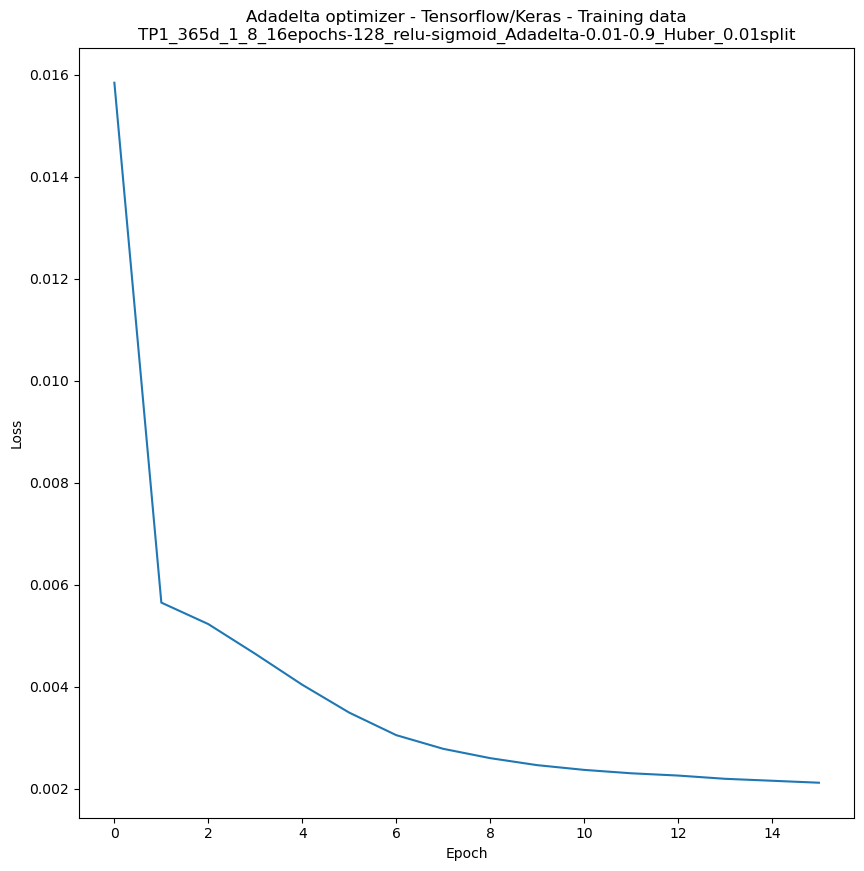

In [13]:
# Plot the loss history
print('Generating the history loss plot')

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)

plt.plot(history.epoch, history.history['loss'])

plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.title('Adadelta optimizer - Tensorflow/Keras - Training data\n' + expname)

plt.rcParams.update({'font.size': 18})

plt.axis(True)
plt.show()

loss_fig_file = os.path.join(path, '../outputs/' + expname + '_loss.png')
fig.savefig(loss_fig_file) 

In [14]:
# Model performance on the whole training data
train_loss = model.evaluate(input_train, output_train)
print("Training Mean Squared Error:", train_loss)

86/86 [==============================] - 0s 3ms/step - loss: 0.0025
Training Mean Squared Error: 0.0024947416968643665


In [15]:
# Model performance on testing data (unseen)
val_loss = model.evaluate(input_test, output_test)
print("Validation  Mean Squared Error:", val_loss)

22/22 [==============================] - 0s 3ms/step - loss: 0.0026
Validation  Mean Squared Error: 0.002636050106957555


In [16]:
# Save model
model_file = os.path.join(path, '../outputs/' + expname + '.h5')
model.save(model_file)

In [17]:
# Load model
# from tensorflow import keras
# loaded_model = keras.models.load_model(model_file)

In [18]:
# Model weights
weights = model.layers[0].get_weights()[0]

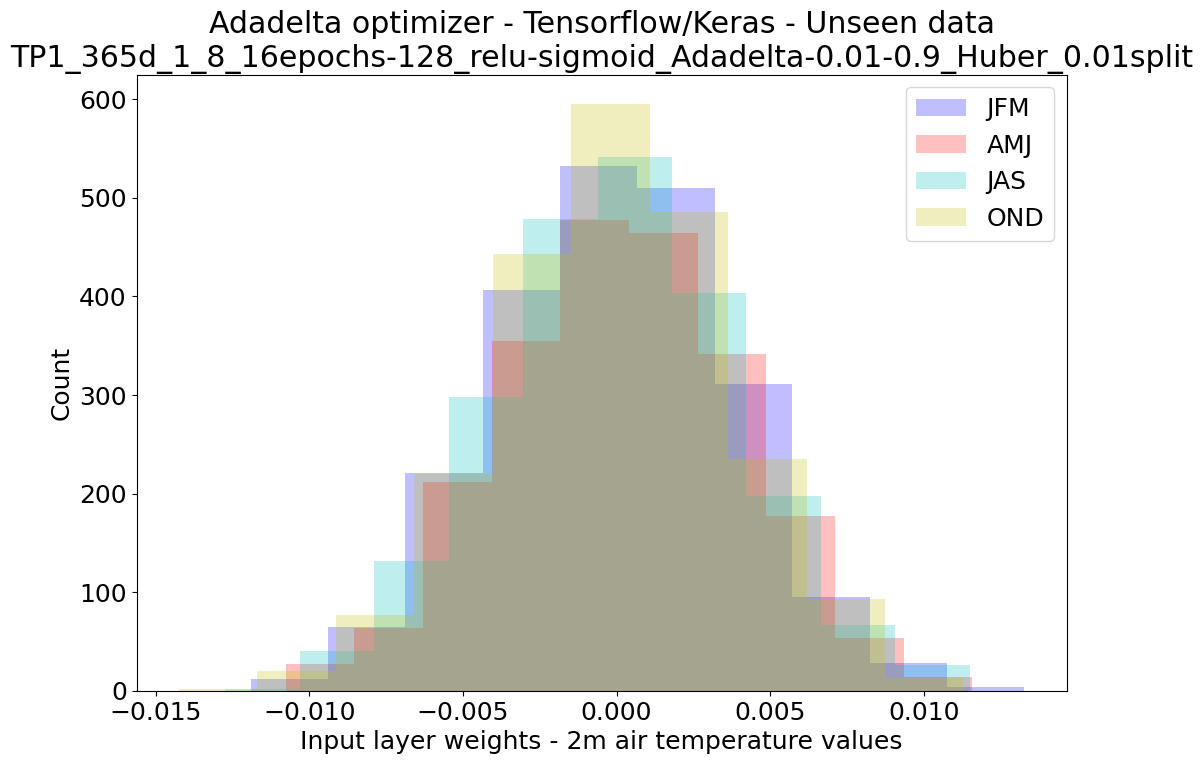

In [19]:
fig = plt.figure(figsize = (12, 8))
ax = fig.add_subplot(111)

color = ['b', 'r', 'c', 'y']
for s in range(1, 5, 1):
    plt.hist(weights[1 + (s-1) * 91 * 24 : 1 + s * 91 * 24, :].mean(axis = 1).flatten(), alpha = 0.25, bins = 10, color = color[s-1])
plt.xlabel('Input layer weights - 2m air temperature values')
ax.set_ylabel('Count')
plt.title('Adadelta optimizer - Tensorflow/Keras - Unseen data\n' + expname)
#plt.xlim(-0.015, 0.015)
ax.legend(['JFM', 'AMJ', 'JAS', 'OND'])
plt.axis(True)
plt.show()

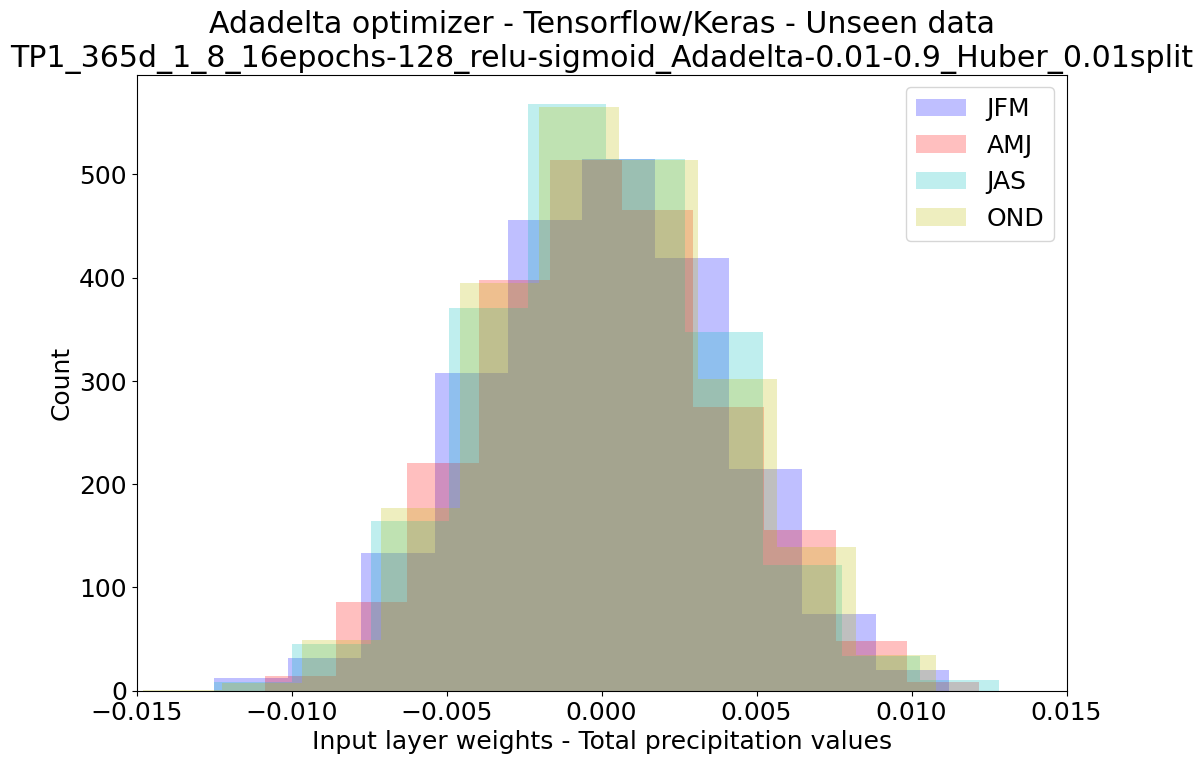

In [20]:
fig = plt.figure(figsize = (12, 8))
ax = fig.add_subplot(111)

color = ['b', 'r', 'c', 'y']
for s in range(1, 5, 1):
    plt.hist(weights[8761 + (s-1) * 91 * 24 : 8761 + s * 91 * 24, :].mean(axis = 1).flatten(), alpha = 0.25, bins = 10, color = color[s-1])
plt.xlabel('Input layer weights - Total precipitation values')
ax.set_ylabel('Count')
plt.title('Adadelta optimizer - Tensorflow/Keras - Unseen data\n' + expname)
plt.xlim(-0.015, 0.015)
ax.legend(['JFM', 'AMJ', 'JAS', 'OND'])
plt.axis(True)
plt.show()

In [21]:
# Applying the model on the entire training dataset
output_train_forecast = model.predict(input_train)

86/86 [==============================] - 0s 2ms/step


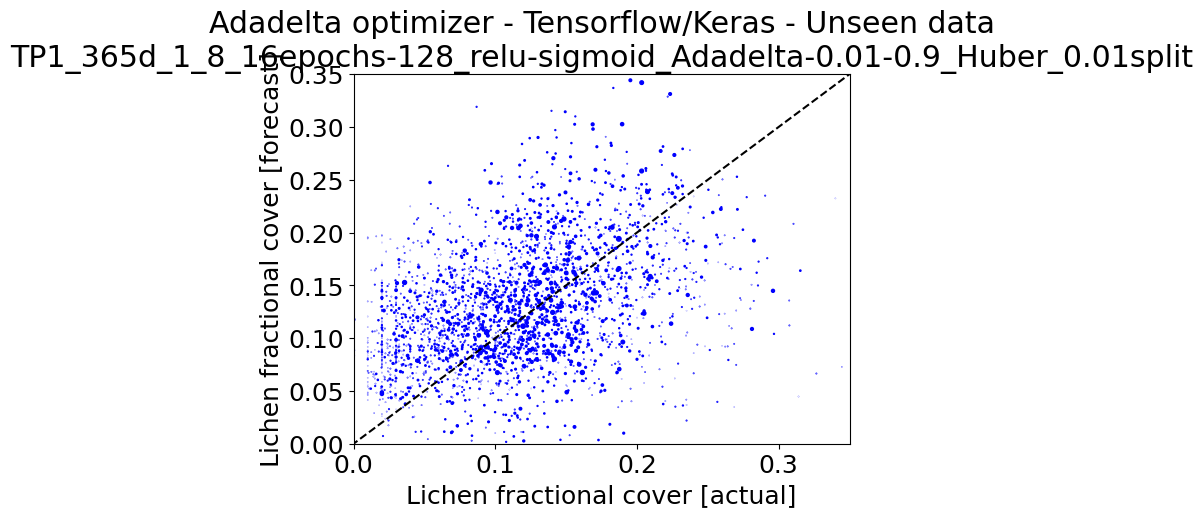

In [22]:
# Forecast vs. actual Values xy-plot - Training data

fig = plt.figure()
ax = fig.add_subplot(111)

plt.scatter(output_train, output_train_forecast, c = 'blue', s = train_loss_weights / 250.)
plt.plot([-5,20], [-5,20], color = 'black', ls = '--')

plt.ylabel('Lichen fractional cover [forecast]')
plt.xlabel('Lichen fractional cover [actual]')
plt.title('Adadelta optimizer - Tensorflow/Keras - Unseen data\n' + expname)

plt.ylim(0., 0.35)
plt.xlim(0., 0.35)

plt.axis(True)
plt.show()

xy_fig_file = os.path.join(path, '../outputs/' + expname + '_xy.png')
fig.savefig(xy_fig_file) 

In [23]:
# Perform a prediction
print('Forecasting', input_test.sum())
output_test_forecast = model.predict(input_test)

Forecasting Lichen_mean      80.026690
t2m_0           662.874611
t2m_1           662.608939
t2m_2           662.445779
t2m_3           662.325428
                  ...     
tp_8755        1218.064686
tp_8756        1273.531603
tp_8757        1326.723500
tp_8758        1377.714448
tp_8759        1426.276104
Length: 17521, dtype: float64
22/22 [==============================] - 0s 2ms/step


In [24]:
output_test_forecast = pd.DataFrame(output_test_forecast.tolist())

In [25]:
output_test_forecast.columns = ['Forecasted_lichen']

In [26]:
output_test = output_test.reset_index().drop(columns=['index'])

In [27]:
output_test.columns = ['Actual_lichen']

In [28]:
# Calculate the cover
C_actual = (No_test.values * output_test['Actual_lichen'].values) * 100 * 100 / 1e06
C_forecast = (No_test.transpose().values * output_test_forecast['Forecasted_lichen'].values) * 100 * 100 / 1e06
TC_actual = C_actual.sum() 
TC_forecast = C_forecast.sum()
print('Total cover [in km2] = ', TC_forecast, ' (vs. ', TC_actual, ' actual)')
print('Total cover difference between actual and forecast [in %] = ', (((TC_actual - TC_forecast) / TC_actual * 100) * 100).astype('int') / 100)

Total cover [in km2] =  220.74091610413979  (vs.  201.21314913167575  actual)
Total cover difference between actual and forecast [in %] =  -9.7


In [29]:
# Obtain m (slope) and b(intercept) of linear regression line
m, b = np.polyfit(output_test['Actual_lichen'], output_test_forecast['Forecasted_lichen'], 1, w = test_loss_weights)

In [30]:
output_test

,Actual_lichen
0,0.070000
1,0.062664
2,0.070323
3,0.117059
4,0.133754
...,...
676,0.074000
677,0.104855
678,0.104464
679,0.138932


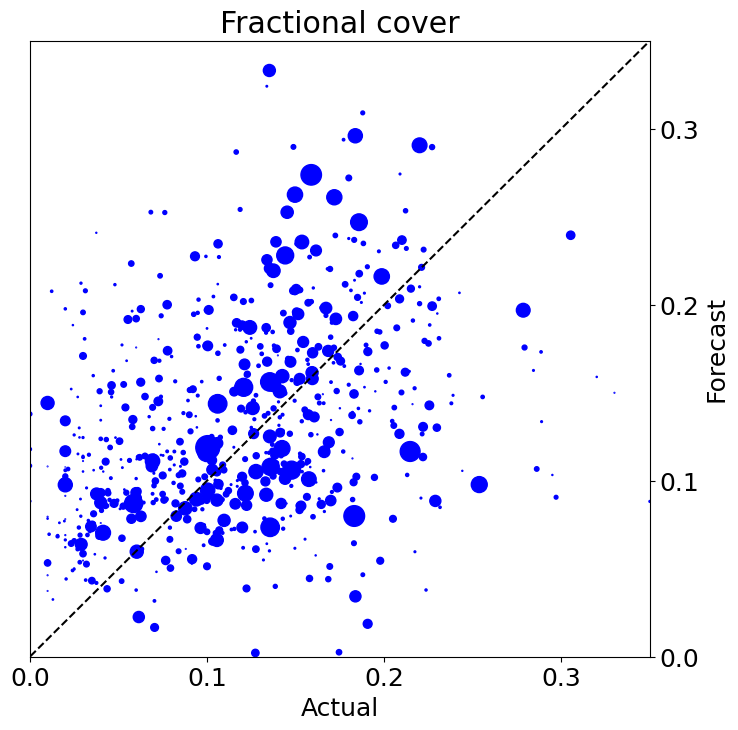

In [31]:
# Forecast vs. actual Values xy-plot - Unseen data

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)

plt.scatter(output_test, output_test_forecast, c = 'blue', s = test_loss_weights / 10.)
plt.plot([-5,20], [-5,20], color = 'black', ls = '--')
#plt.plot(output_test['Actual_lichen'], m * output_test['Actual_lichen'] + b, color = 'red', ls = 'dotted')

plt.ylabel('Forecast')
ax.yaxis.set_label_position("right")
ax.yaxis.tick_right()
plt.xlabel('Actual')
plt.title('Fractional cover')
#plt.title('Adadelta optimizer - Tensorflow/Keras - Unseen data\n' + expname)

plt.ylim(0., 0.35)
plt.xlim(0., 0.35)
plt.rcParams.update({'font.size': 32})

plt.axis(True)
plt.show()

xy_fig_file = os.path.join(path, '../outputs/' + expname + '_xy.png')
fig.savefig(xy_fig_file) 

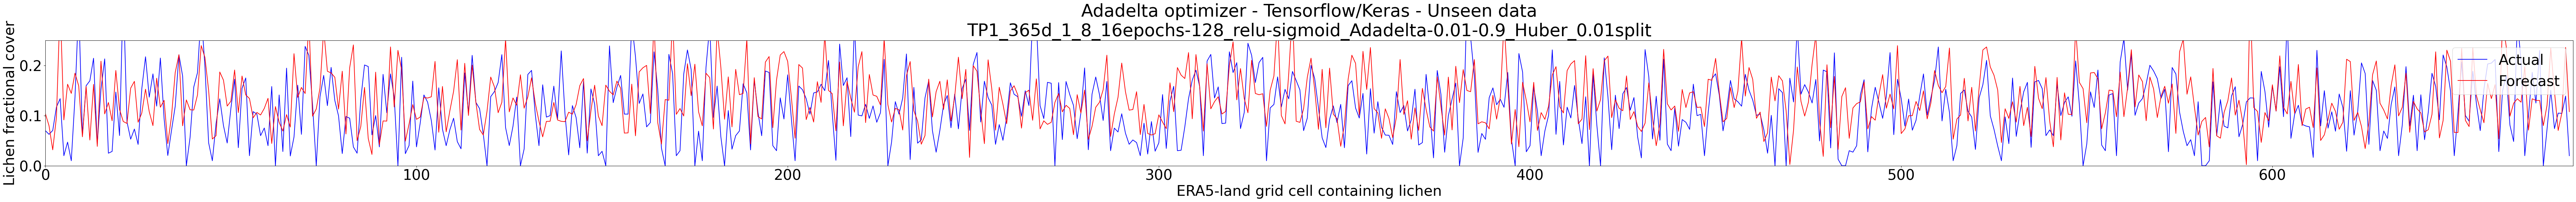

In [32]:
# Forecast vs. actual Values linear-plot - Unseen data

fig = plt.figure(figsize=(100, 5))
ax = fig.add_subplot(111)

plt.plot(output_test, c = 'blue')
plt.plot(output_test_forecast, c = 'red')

plt.ylabel('Lichen fractional cover')
plt.xlabel('ERA5-land grid cell containing lichen')
plt.title('Adadelta optimizer - Tensorflow/Keras - Unseen data\n' + expname)

plt.xlim(0., len(output_test))
plt.ylim(0., 0.25)
ax.legend(['Actual', 'Forecast'])

LFC_fig_file = os.path.join(path, '../outputs/' + expname + '_LFC.png')
fig.savefig(LFC_fig_file) 

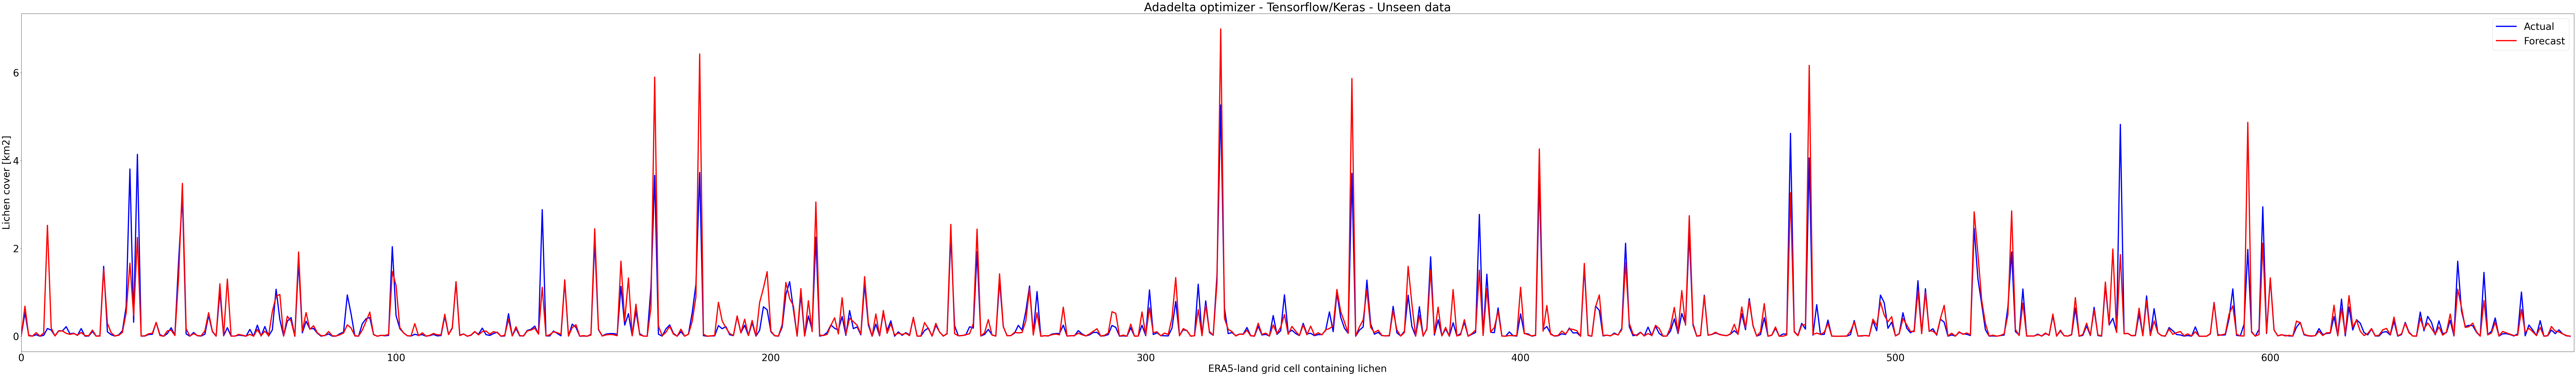

In [33]:
# Forecast vs. actual cover linear-plot - Unseen data

fig = plt.figure(figsize=(150, 20), linewidth=2)
ax = fig.add_subplot(111)

plt.plot(C_actual, c = 'blue', linewidth=4)
plt.plot(C_forecast, c = 'red', linewidth=4)

plt.ylabel('Lichen cover [km2]')
plt.xlabel('ERA5-land grid cell containing lichen')
plt.title('Adadelta optimizer - Tensorflow/Keras - Unseen data')
#plt.title('Adadelta optimizer - Tensorflow/Keras - Unseen data\n' + expname)

plt.xlim(0., len(C_actual))
ax.legend(['Actual', 'Forecast'])
plt.rcParams.update({'font.size': 128})

LSC_fig_file = os.path.join(path, '../outputs/' + expname + '_LSC.png')
fig.savefig(LSC_fig_file, bbox_inches='tight') 